# Hipótese 2 — Concentração dos Bancos (PEAC)

**Projeto Aplicado - GRUPO 19**  
**Objetivo:** Avaliar o grau de concentração bancária no PEAC, identificando os bancos com maior participação no volume total de crédito contratado.



In [1]:
# %%
# === IMPORTAÇÃO DE BIBLIOTECAS ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import os

# Estilo dos gráficos
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

# Caminhos
PASTA_DATA = "../Data"
PASTA_RESULTADOS = "../Resultados"
os.makedirs(PASTA_RESULTADOS, exist_ok=True)


In [2]:
# %%
# === LEITURA DO DATASET ===
arquivo_csv = os.path.join(PASTA_DATA, "PEAC2022.csv")
dados = pd.read_csv(arquivo_csv, sep=";", decimal=",", encoding="latin1")

# Padronizar colunas
dados.columns = dados.columns.str.lower().str.strip()

print(f"Dataset carregado com sucesso!")
print(f"Shape: {dados.shape}")
print(f"Colunas: {list(dados.columns)}")

dados.head()

Dataset carregado com sucesso!
Shape: (453688, 12)
Colunas: ['nome_agente_financeiro', 'cnpj_cpf_cliente', 'nome_cliente', 'porte_cliente', 'valor_credito', 'valor_garantido', 'valor_desembolsado', 'data_solicitacao_outorga', 'municipio_investimento', 'uf_investimento', 'municipio_sede_cliente', 'uf_sede_cliente']


,nome_agente_financeiro,cnpj_cpf_cliente,nome_cliente,porte_cliente,valor_credito,valor_garantido,valor_desembolsado,data_solicitacao_outorga,municipio_investimento,uf_investimento,municipio_sede_cliente,uf_sede_cliente
0,ITAU,**.*43.060/0001-**,FERAMAR DISTRIBUIDORA T P L ME,Média,1.000.000,800.000,1.000.000,2022-09-15,NITEROI,RJ,NITEROI,RJ
1,ITAU,**.*86.809/0001-**,MASTER S.P.R. INS ELETRICAS,Média,200.000,160.000,200.000,2022-09-15,PEDREIRA,SP,PEDREIRA,SP
2,ITAU,**.*62.167/0001-**,I E C RODRIGUES - ME,Média,200.000,160.000,200.000,2022-09-21,CAMAQUA,RS,CAMAQUA,RS
3,ITAU,**.*49.182/0001-**,CLINUTRI LTDA EPP,Média,200.000,160.000,200.000,2022-09-19,RECIFE,PE,RECIFE,PE
4,ITAU,**.*47.450/0001-**,UTILIDADES GOURMET COM EIRELI,Média,1.500.000,1.200.000,1.500.000,2022-09-23,JUNDIAI,SP,JUNDIAI,SP


In [3]:
# %%
# ============ 2. Limpar e padronizar colunas ============
dados.columns = dados.columns.str.strip().str.lower()

# Detectar colunas corretas automaticamente (como no script original)
col_valor = next((c for c in dados.columns if "valor" in c), None)
col_banco = next((c for c in dados.columns if "banco" in c or "agente" in c), None)

if not col_valor or not col_banco:
    raise ValueError("Não encontrei colunas de 'valor' e 'banco' no CSV!")

# Renomear para as variáveis usadas no script
dados = dados.rename(columns={col_valor: "valor_credito", col_banco: "banco"})


In [4]:
# %%
# ============ 3. Limpar valores numéricos ============
dados["valor_credito"] = (
    dados["valor_credito"]
    .astype(str)
    .str.replace("R\$", "", regex=True)
    .str.replace("\.", "", regex=True)
    .str.replace(",", ".", regex=True)
)

dados["valor_credito"] = pd.to_numeric(dados["valor_credito"], errors="coerce")
dados = dados.dropna(subset=["valor_credito", "banco"])

print("Registros após limpeza:", dados.shape)


<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\.'
C:\Users\FelipeB\AppData\Local\Temp\ipykernel_15616\3021685840.py:6: SyntaxWarning: invalid escape sequence '\$'
  .str.replace("R\$", "", regex=True)
C:\Users\FelipeB\AppData\Local\Temp\ipykernel_15616\3021685840.py:7: SyntaxWarning: invalid escape sequence '\.'
  .str.replace("\.", "", regex=True)


Registros após limpeza: (453688, 12)


In [5]:
# %%
# ============ 4. Calcular totais ============
ranking_bancos = (
    dados.groupby("banco")
    .agg(total_valor=("valor_credito", "sum"),
         total_operacoes=("valor_credito", "count"))
    .reset_index()
)

# ============ 5. Calcular participação ============
ranking_bancos["pct_valor"] = (ranking_bancos["total_valor"] /
                               ranking_bancos["total_valor"].sum()) * 100
ranking_bancos["pct_operacoes"] = (ranking_bancos["total_operacoes"] /
                                   ranking_bancos["total_operacoes"].sum()) * 100

# ============ 6. Selecionar Top 10 ============
top10 = ranking_bancos.sort_values("total_valor", ascending=False).head(10).copy()
top10["total_valor_bi"] = top10["total_valor"] / 1_000_000_000  # bilhões

top10.head()


,banco,total_valor,total_operacoes,pct_valor,pct_operacoes,total_valor_bi
31,ITAU,3.762405e+10,82612,19.857745,18.208989,37.624049
13,BRADESCO,3.702745e+10,75355,19.542865,16.609432,37.027452
18,CAIXA ECONOMICA,2.005686e+10,98730,10.585887,21.761651,20.056856
40,SANTANDER,1.879998e+10,23256,9.922518,5.125990,18.799985
6,BANCO DO BRASIL,1.634181e+10,32672,8.625110,7.201425,16.341812


C:\Users\FelipeB\AppData\Local\Temp\ipykernel_15616\2335441121.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


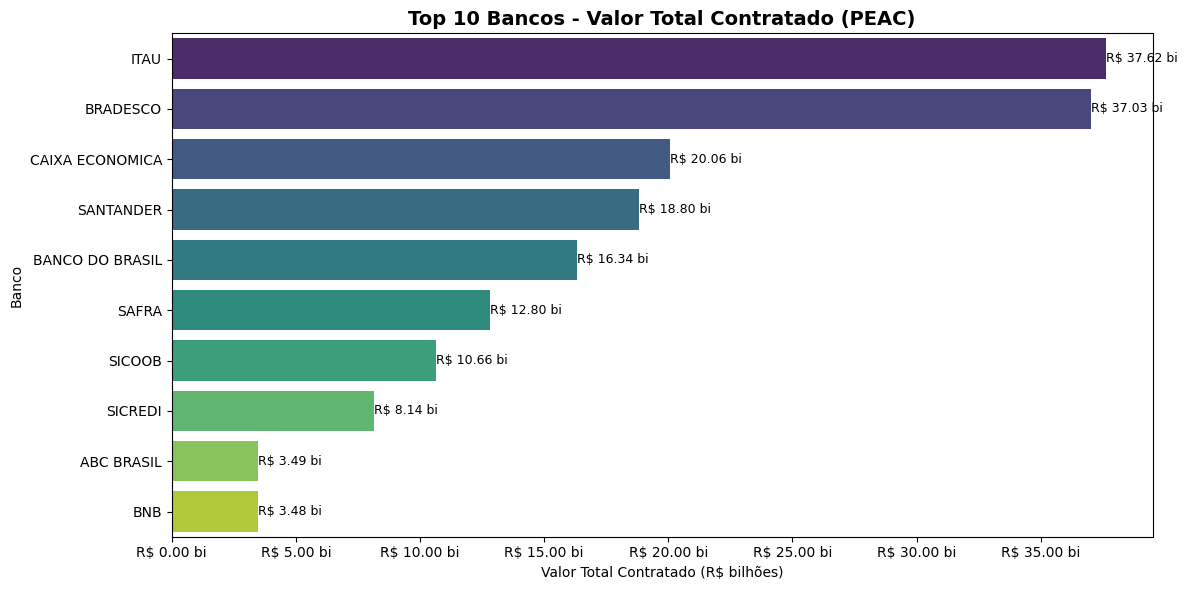

✅ Gráfico salvo como: ../Resultados\top10_bancos_PEAC.png


In [6]:
# %%
# ============ 7. Gráfico 1 - Valor total ============
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10,
    y="banco",
    x="total_valor_bi",
    palette="viridis"
)

plt.title("Top 10 Bancos - Valor Total Contratado (PEAC)", fontsize=14, weight="bold")
plt.xlabel("Valor Total Contratado (R$ bilhões)")
plt.ylabel("Banco")
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('R$ {x:,.2f} bi'))

# Rótulos com valores
for i, v in enumerate(top10["total_valor_bi"]):
    plt.text(v, i, f"R$ {v:,.2f} bi", va="center", fontsize=9)

plt.tight_layout()

# Salvar gráfico em Resultados
caminho_grafico1 = os.path.join(PASTA_RESULTADOS, "top10_bancos_PEAC.png")
plt.savefig(caminho_grafico1, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Gráfico salvo como: {caminho_grafico1}")


C:\Users\FelipeB\AppData\Local\Temp\ipykernel_15616\1566937988.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


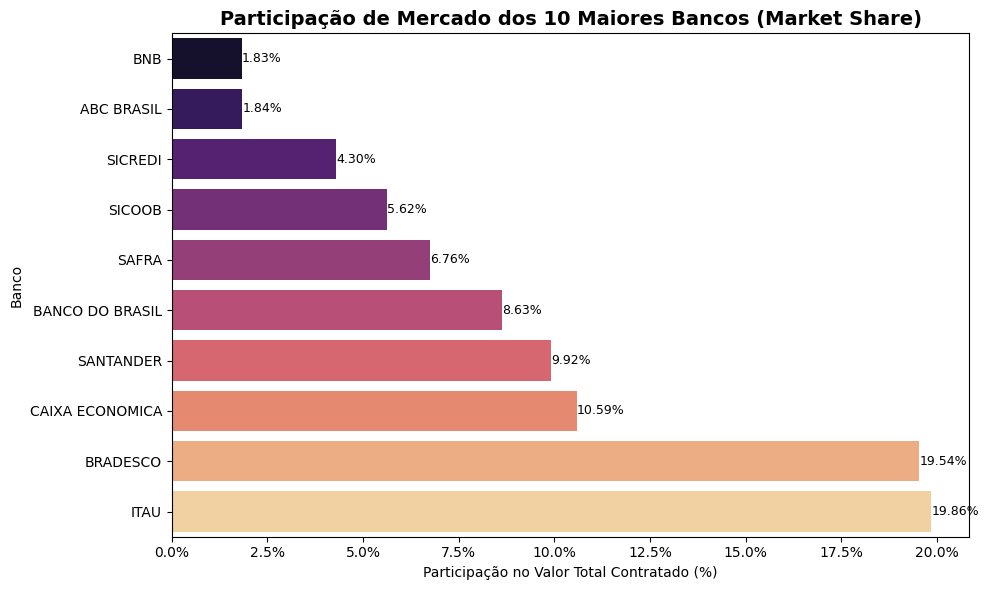

Gráfico salvo como: ../Resultados\market_share_bancos_PEAC.png


In [7]:
# %%
# ============ 8. Gráfico 2 - Market share ============
top10_sorted = top10.sort_values("pct_valor", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_sorted,
    y="banco",
    x="pct_valor",
    palette="magma"
)

plt.title("Participação de Mercado dos 10 Maiores Bancos (Market Share)", fontsize=14, weight="bold")
plt.xlabel("Participação no Valor Total Contratado (%)")
plt.ylabel("Banco")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

# Rótulos com porcentagens
for i, v in enumerate(top10_sorted["pct_valor"]):
    plt.text(v, i, f"{v:.2f}%", va="center", fontsize=9)

plt.tight_layout()

# Salvar gráfico em Resultados
caminho_grafico2 = os.path.join(PASTA_RESULTADOS, "market_share_bancos_PEAC.png")
plt.savefig(caminho_grafico2, dpi=300, bbox_inches="tight")
plt.show()

print(f"Gráfico salvo como: {caminho_grafico2}")


In [8]:
# %%
# ============ 9. Mostrar resumo no terminal ============
print("\n===== TOP 10 BANCOS - VALOR TOTAL =====")
print(top10[["banco", "total_valor_bi", "pct_valor", "total_operacoes", "pct_operacoes"]])

print("\n Gráficos salvos como:")
print(f" - {caminho_grafico1}")
print(f" - {caminho_grafico2}")



===== TOP 10 BANCOS - VALOR TOTAL =====
              banco  total_valor_bi  pct_valor  total_operacoes  pct_operacoes
31             ITAU       37.624049  19.857745            82612      18.208989
13         BRADESCO       37.027452  19.542865            75355      16.609432
18  CAIXA ECONOMICA       20.056856  10.585887            98730      21.761651
40        SANTANDER       18.799985   9.922518            23256       5.125990
6   BANCO DO BRASIL       16.341812   8.625110            32672       7.201425
39            SAFRA       12.798981   6.755225            13299       2.931310
42           SICOOB       10.656151   5.624252            40811       8.995389
43          SICREDI        8.137875   4.295121            31901       7.031484
0        ABC BRASIL        3.489510   1.841742             1904       0.419672
12              BNB        3.476303   1.834771             7001       1.543131

 Gráficos salvos como:
 - ../Resultados\top10_bancos_PEAC.png
 - ../Resultados\market_sha